<a href="https://colab.research.google.com/github/jjrodcast/SocialDistanceDetector/blob/master/Social_Distance_Detector_BirdsEye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Bird's eye on a frame

### Capturamos el primer frame para obtener la matríz de homografía



In [0]:
# En caso quiera tomar algun frame del video 

#capture = cv2.VideoCapture('TownCentreXVID.avi')
#ret, frame = capture.read()
#print(ret)
#cv2.imwrite('calibration_frame.jpg', frame)
#capture.release()

Image size:  (1080, 1920, 3)


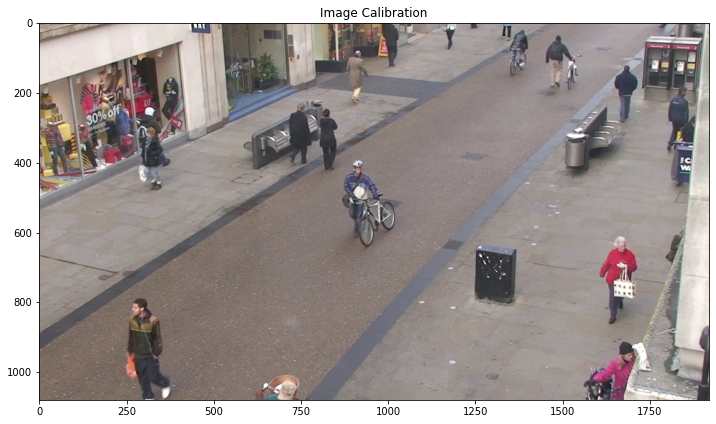

In [5]:
image_original = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB) 
image_calibration = image_original.copy()
print("Image size: ", image_original.shape)
plt.figure(figsize=(12, 12))
plt.title("Image Calibration")
plt.imshow(image_original)
plt.show()

### Defining points on the calibration image

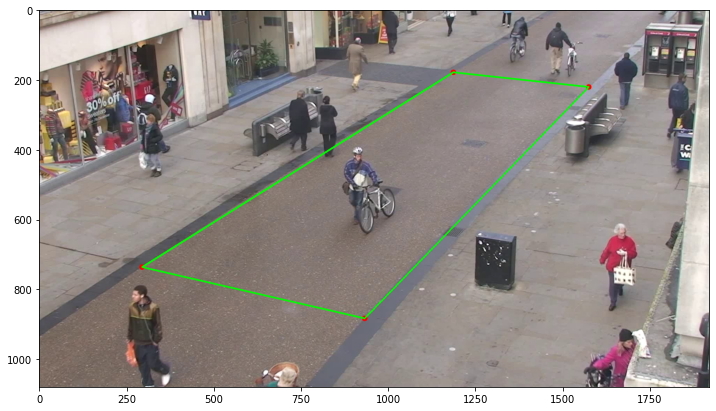

In [6]:
high_ori = image_calibration.shape[0]
weight_ori = image_calibration.shape[1]

source_points = np.float32([[1187, 178], [1575, 220], [933,883], [295, 736]])

image_calibration_points = image_calibration.copy()

# Drawing points from calibration image
for point in source_points:
    cv2.circle(image_calibration_points, tuple(point), 8, (255, 0, 0), -1)

# Drawing lines to join the points
points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(image_calibration_points, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(image_calibration_points)
plt.show()

### Defining and Applying function to warp perspective

In [0]:
def perspective_warp(img,
                     dst_size=(1000,1000),
                     src=np.float32([(0,0),(0,0),(0,0),(0,0)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    
    img_size = np.float32([(img.shape[1],img.shape[0])])

    # Points of destination on the result image
    dst = dst * np.float32(dst_size)

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

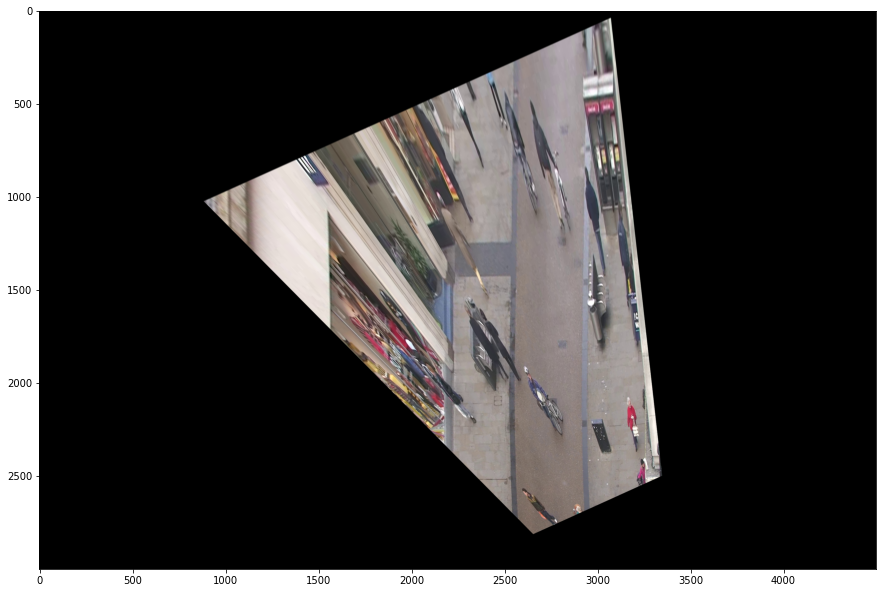

In [8]:
res = perspective_warp(image_calibration,
                     dst_size=(4500,3000),
                     src=np.float32([[1187, 178], [1575, 220], [933,883], [295, 736]]),
                     dst=np.float32([(0.57,0.42), (0.65, 0.42), (0.65,0.84), (0.57,0.84)]))

plt.figure(figsize=(15, 15))
plt.imshow(res)
plt.show()

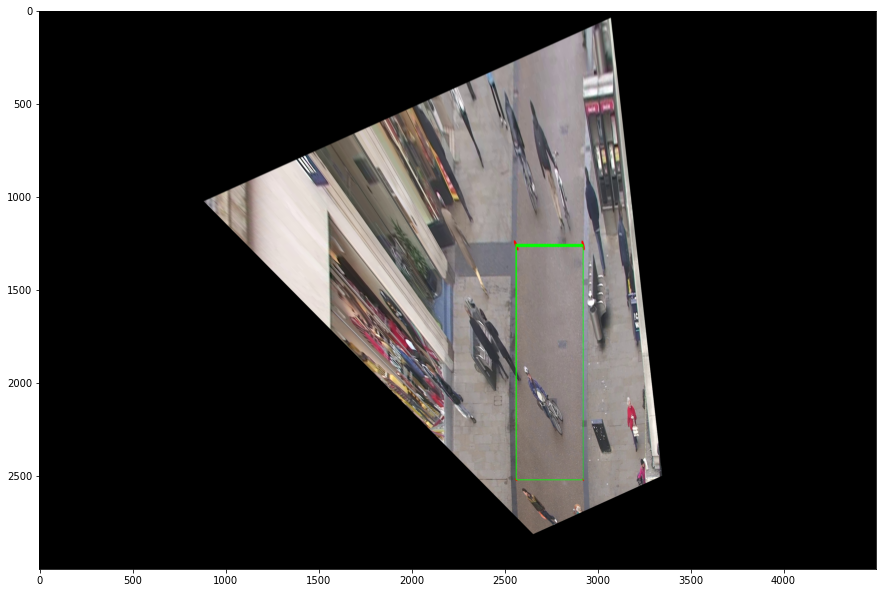

In [9]:
# Looking the image with calibration points
res_review = perspective_warp(image_calibration_points,
                     dst_size=(4500,3000),
                     src=np.float32([[1187, 178], [1575, 220], [933,883], [295, 736]]),
                     dst=np.float32([(0.57,0.42), (0.65, 0.42), (0.65,0.84), (0.57,0.84)]))

plt.figure(figsize=(15, 15))
plt.imshow(res_review)
plt.show()

In [0]:
### Probando sobreponer una imagen sobre un background

In [0]:
import cv2

img_ori = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB) 
ratio_expansion = 2 # >1

weight, high, channels = img_ori.shape

background = np.zeros((int(ratio_expansion*weight), int(ratio_expansion*high), channels), dtype=np.uint8)

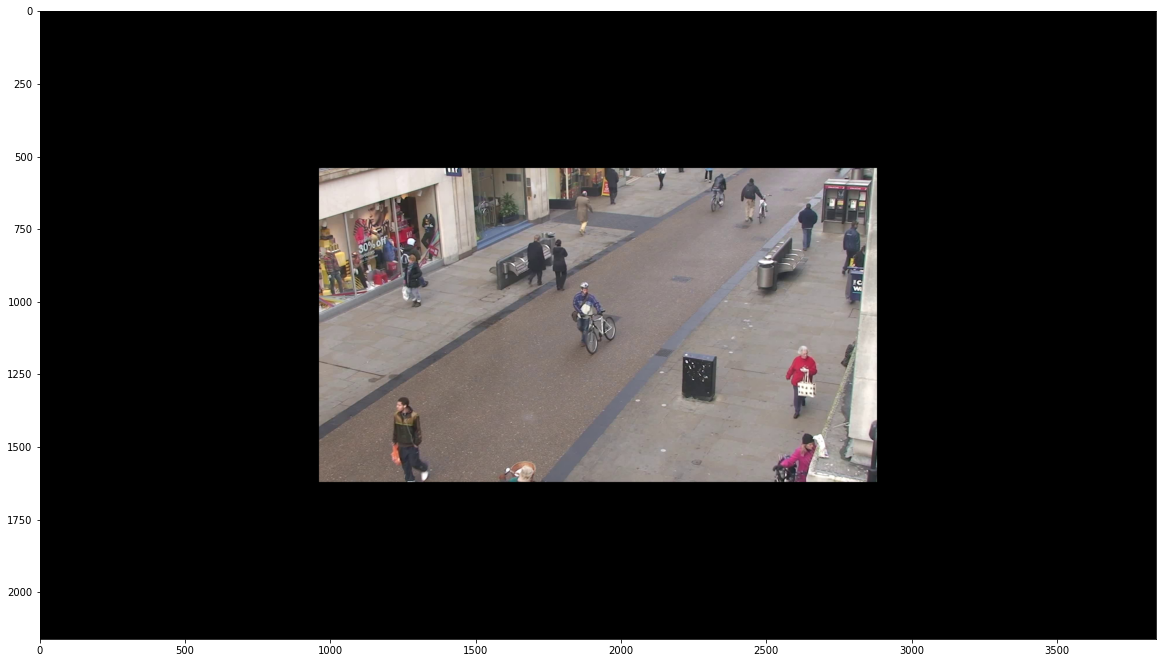

In [12]:
overlay = img_ori.copy()

#overlay=cv2.addWeighted(background[0:0+rows, 0:0+cols],0,overlay,1,0,)

pos_x, pos_y = int((ratio_expansion-1)*weight/2), int((ratio_expansion-1)*high/2)

background[pos_x:pos_x+weight, pos_y:pos_y+high ] = overlay

plt.figure(figsize=(20,20))
plt.imshow(background)
plt.show()

##2. Detector de personas con YOLOv3


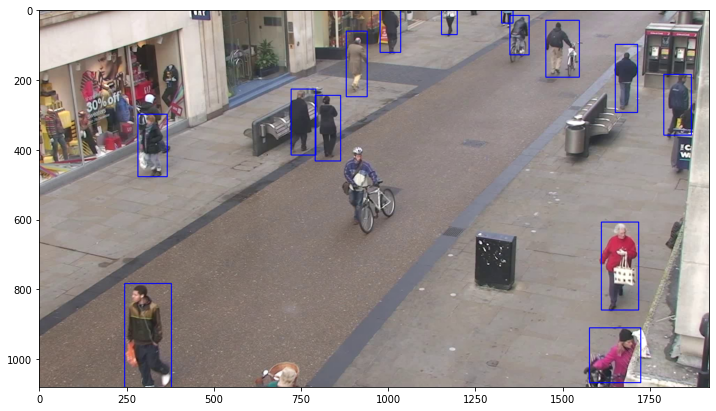

In [21]:
#Referencia: https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/
confidence_threshold = 0.5
nms_threshold = 0.5
input_width = 416
input_height = 416
model_config_name = 'yolov3.cfg'
model_weights_name = 'yolov3.weights'
model_classes_name = 'coco.names'
classes = None
with open(model_classes_name, 'rt') as f:
  classes = f.read().strip('\n').split('\n')


#W = None
#H = None
#writer = None

"""
video = cv2.VideoCapture('TownCentreXVID.avi')

while True:
  _, frame = video.read()

  if frame is None:
    break

  if W is None or H is None:
    (H, W) = frame.shape[:2]
  
  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output_video.avi', fourcc, 30, (W, H), True)
  
  img_color = cv2.cvtColor(frame, cv2.COLOR_GBR2RGB)
"""

# Step 1: Create the model
model = cv2.dnn.readNetFromDarknet(model_config_name, model_weights_name)
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Step 2: Get the Output Layers
layer_names = model.getLayerNames()
output_names = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]

# Step 3: Read the image or frame (video)
image_ori = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB)
image = image_ori.copy()

# Step 4: Create blob from image or frame
blob = cv2.dnn.blobFromImage(image, 
                             1/255., 
                             (input_width, input_height), 
                             [0,0,0],
                             1,
                             crop=False)

# Step 5: Set input to model and do forward pass
model.setInput(blob)
outputs = model.forward(output_names)

# Step 6: Apply non maximum supression
#frame = image, outs = outputs
img_height = image.shape[0]
img_width = image.shape[1]
classIds = []
confidences = []
boxes = []
for output in outputs:
  for detection in output:
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > confidence_threshold:
      center_x = int(detection[0] * img_width)
      center_y = int(detection[1] * img_height)
      width = int(detection[2] * img_width)
      height = int(detection[3] * img_height)
      left = int(center_x - width / 2)
      top = int(center_y - height / 2)
      classIds.append(classId)
      confidences.append(float(confidence))
      boxes.append([left, top, width, height])

indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

# Step 7: Draw Bounding boxes
for index in indices:
  index = index[0]
  i_class = classes[classIds[index]]
  if i_class == 'person':  
    box = boxes[index]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    cv2.rectangle(image, (left, top), (left + width, top + height), (0,0,255), 2)
    #i_label = f'{confidences[index]:.2f}'
    #label = f'{str(i_class)}:{str(i_label)}'
    #label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.)
    #top = max(top, label_size[1])
    #cv2.putText(image, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,255))

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.show()

### Aplying Bird's Eye

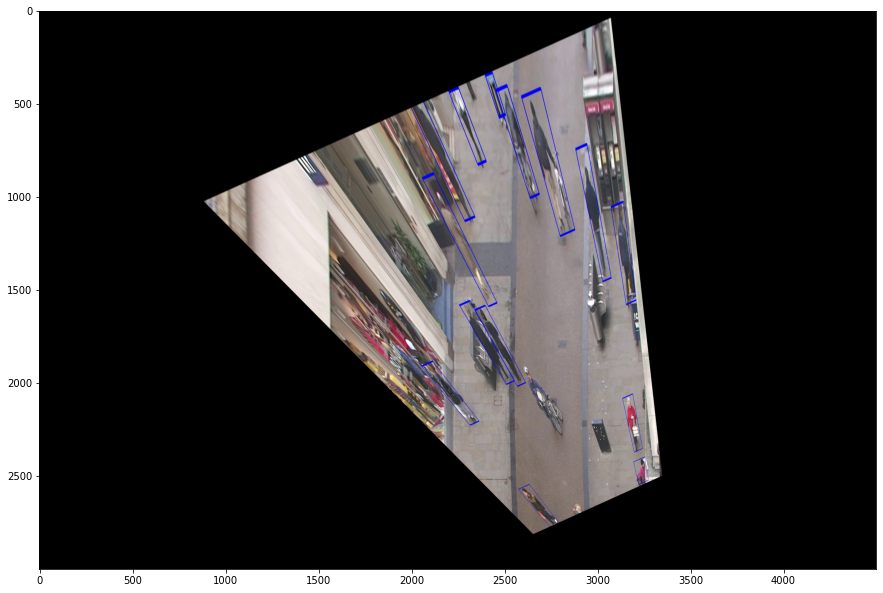

In [22]:
res_review = perspective_warp(image,
                     dst_size=(4500,3000),
                     src=np.float32([[1187, 178], [1575, 220], [933,883], [295, 736]]),
                     dst=np.float32([(0.57,0.42), (0.65, 0.42), (0.65,0.84), (0.57,0.84)]))

plt.figure(figsize=(15, 15))
plt.imshow(res_review)
plt.show()

New size: (1400, 2800)


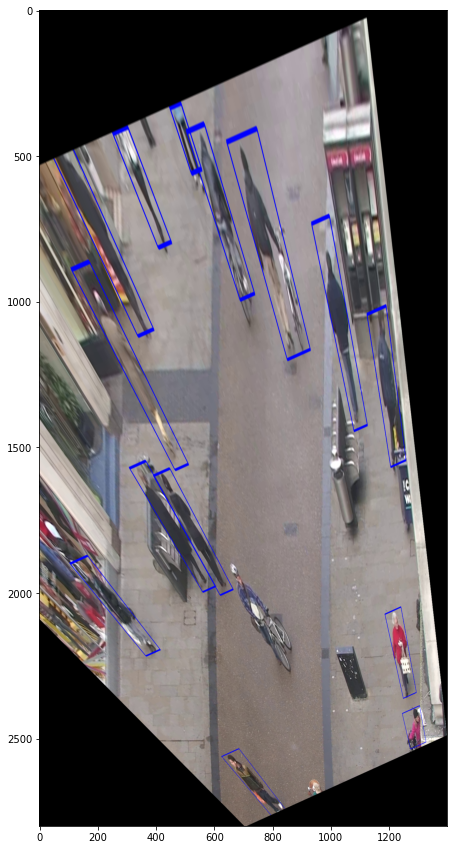

In [33]:
#parametros de posición
cut_posX_min,cut_posX_max = 1950,3350 
cut_posY_min,cut_posY_max = 10,2810

#resultados
new_size = (cut_posX_max-cut_posX_min, cut_posY_max-cut_posY_min)
print("New size:", new_size)

res_review_sel = res_review[cut_posY_min:cut_posY_max, cut_posX_min:cut_posX_max, :]
plt.figure(figsize=(15, 15))
plt.imshow(res_review_sel)
plt.show()